## Data reading and Data Insights

**Listening to Music Participant: maezab9d, 16 days participation**

*Dataset:* 'Listening to Music' vs 'Not Listening to Music' study




#### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import pymc as pm
import arviz as az

In [3]:
path = "C://Users//USER//Desktop//StudyU_Results//"
df_intervention = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-__listening_to_music_-_maezab9d_2025-05-08 09_43_57.286//interventions.csv")
#print(df_intervention.head())
df_mea = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-__listening_to_music_-_maezab9d_2025-05-08 09_43_57.286//measurements.csv")
#print(df_mea.head())

## Data Analysis and Preprocessing

- Pre-analysis: maezab9d
    - Number of Participant
    - Participation of the study
    - Missing Values
    - Remove Participants Who Joined Outside the Study
    - Data Preperation

#### Number of Participant

In [4]:
column_name = 'participant_id' 

unique_count = df_intervention[column_name].nunique()

if unique_count == 1:
    only_value = df_intervention[column_name].iloc[0]
    print(f"The column '{column_name}' has only one unique value: {only_value!r}")
else:
    print(f"The column '{column_name}' has {unique_count} unique values.")
    print("Unique values are:", df_intervention[column_name].unique())

The column 'participant_id' has only one unique value: '2e1f502a-d65c-46c7-af27-f7748c22f2ab'


#### Participation of the study

In [5]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'], utc=True)

participation_days = (
    df_mea
    .groupby('participant_id')['measurement_time']
    .apply(lambda x: x.dt.date.nunique())
    .reset_index(name='participation_days')
)

print(participation_days)

                         participant_id  participation_days
0  2e1f502a-d65c-46c7-af27-f7748c22f2ab                  16


As anticipated, the study comprised a single participant, with a total participation period of 16 days.

#### Missing Values

In [6]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in ['Outcome', 'Mediators']:
        sub = df_part[df_part['measurement_name'] == name].copy()
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=16, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),            # should be 16
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 2e1f502a-d65c-46c7-af27-f7748c22f2ab ---

  Outcome:
    Start date:           2025-04-21
    End of expected 16d:  2025-05-06
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  Mediators:
    Start date:           2025-04-21
    End of expected 16d:  2025-05-06
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0


#### Remove Participants Who Joined Outside the Study

In [7]:
# df_mea = df_mea[df_mea['participant_id'] != "ca773388-eb42-4716-995a-476ed72c0475"]
# df_mea.shape[0]

#### Data Preperation

In [8]:
df_mea_all= df_mea[[
     'measurement_time',
     'measurement_name',
     'participant_id',
     'current_day_of_study',
     'current_intervention_name',
     'survey1_question1_response',
     'survey1_question2_response',
     'survey1_question3_response',
     'survey1_question4_response',
     'survey2_question1_response',
     'survey2_question2_response']]
df_mea_all.head(1)
    

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
0,2025-05-06 19:01:20.016213+00:00,Mediators,2e1f502a-d65c-46c7-af27-f7748c22f2ab,15,Listening to music!,NaN,NaN,NaN,NaN,5.0,7.0


In [9]:
df_mea_m = df_mea_all[df_mea_all['measurement_name'] == 'Mediators']
df_mea_o = df_mea_all[df_mea_all['measurement_name'] == 'Outcome']

In [10]:
df_mea_o = df_mea_o.sort_values(by=['participant_id', 'current_day_of_study'])
df_mea_m = df_mea_m.sort_values(by=['participant_id', 'current_day_of_study'])

In [11]:
df_mea_o.head()

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
31,2025-04-21 19:20:23.177743+00:00,Outcome,2e1f502a-d65c-46c7-af27-f7748c22f2ab,0,Listening to music!,7.0,9.0,5.0,1.0,NaN,NaN
29,2025-04-22 20:34:33.091722+00:00,Outcome,2e1f502a-d65c-46c7-af27-f7748c22f2ab,1,Listening to music!,9.0,8.0,5.0,1.0,NaN,NaN
27,2025-04-23 20:33:18.779702+00:00,Outcome,2e1f502a-d65c-46c7-af27-f7748c22f2ab,2,Listening to music!,6.0,7.0,5.0,1.0,NaN,NaN
25,2025-04-24 19:18:56.017919+00:00,Outcome,2e1f502a-d65c-46c7-af27-f7748c22f2ab,3,Listening to music!,9.0,8.0,2.0,1.0,NaN,NaN
22,2025-04-25 19:00:36.144754+00:00,Outcome,2e1f502a-d65c-46c7-af27-f7748c22f2ab,4,Not listening to music!,5.0,7.0,1.0,5.0,NaN,NaN


## Exploratory Data Analysis - Outcome

- EDA Steps  
  - Data shape  
  - Data types of columns  
  - Missing values  
  - Summary statistics  
  - Data Visualization and Distributions  
    - Plot histograms and box plots  
    - Line plot  
    - Scatter plot  
    - Correlations (Pearson, Kendall, Spearman)   

#### Data Shape

In [12]:
print("Outcome Data Shape")
print("Rows:", df_mea_o.shape[0])
print("Columns:", df_mea_o.shape[1])

Outcome Data Shape
Rows: 16
Columns: 11


#### Data Types of columns

In [13]:
print("Outcome Data Types of Columns")
data_types = df_mea_o.dtypes
data_types_df = pd.DataFrame(data_types, columns=["Data Type"])
print(data_types_df)

Outcome Data Types of Columns
                                      Data Type
measurement_time            datetime64[ns, UTC]
measurement_name                         object
participant_id                           object
current_day_of_study                      int64
current_intervention_name                object
survey1_question1_response              float64
survey1_question2_response              float64
survey1_question3_response              float64
survey1_question4_response              float64
survey2_question1_response              float64
survey2_question2_response              float64


#### Missing Value Analysis

In [14]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

df_mea.columns = df_mea.columns.str.strip()
df_mea['measurement_name'] = df_mea['measurement_name'].str.strip()

measurement_names = [
    'Outcome',
    'Mediators',
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response',
    'survey2_question1_response',
    'survey2_question2_response'
]

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in measurement_names:
        if name in ['Outcome', 'Mediators']:
            sub = df_part[df_part['measurement_name'] == name].copy()
        else:
            if name not in df_part.columns:
                sub = pd.DataFrame()
            else:
                sub = df_part[df_part[name].notna()].copy()
        
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=16, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),      
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant 2e1f502a-d65c-46c7-af27-f7748c22f2ab ---

  Outcome:
    Start date:           2025-04-21
    End of expected 16d:  2025-05-06
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  Mediators:
    Start date:           2025-04-21
    End of expected 16d:  2025-05-06
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question1_response:
    Start date:           2025-04-21
    End of expected 16d:  2025-05-06
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question2_response:
    Start date:           2025-04-21
    End of expected 16d:  2025-05-06
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question3_response:
    Start date:           2025-04-21
    End of expected 16d:  2025-05-06
    Expected days count:  16
    Completed days count: 16
    Missed days count:    0

  survey1_question4_re

#### Summary Statistics

In [15]:
print("Sleep Data Summary Statistics")
summary_stats = df_mea_o.describe()
print(summary_stats)

Sleep Data Summary Statistics
       current_day_of_study  survey1_question1_response  \
count             16.000000                   16.000000   
mean               7.500000                    5.687500   
std                4.760952                    1.662077   
min                0.000000                    4.000000   
25%                3.750000                    4.000000   
50%                7.500000                    5.500000   
75%               11.250000                    6.250000   
max               15.000000                    9.000000   

       survey1_question2_response  survey1_question3_response  \
count                   16.000000                   16.000000   
mean                     6.562500                    3.750000   
std                      1.504161                    2.840188   
min                      4.000000                    1.000000   
25%                      5.750000                    1.000000   
50%                      7.000000               

In [16]:
df_mea_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 31 to 1
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   measurement_time            16 non-null     datetime64[ns, UTC]
 1   measurement_name            16 non-null     object             
 2   participant_id              16 non-null     object             
 3   current_day_of_study        16 non-null     int64              
 4   current_intervention_name   16 non-null     object             
 5   survey1_question1_response  16 non-null     float64            
 6   survey1_question2_response  16 non-null     float64            
 7   survey1_question3_response  16 non-null     float64            
 8   survey1_question4_response  16 non-null     float64            
 9   survey2_question1_response  0 non-null      float64            
 10  survey2_question2_response  0 non-null      float64            
dtype

#### Data Visualization and Distributions

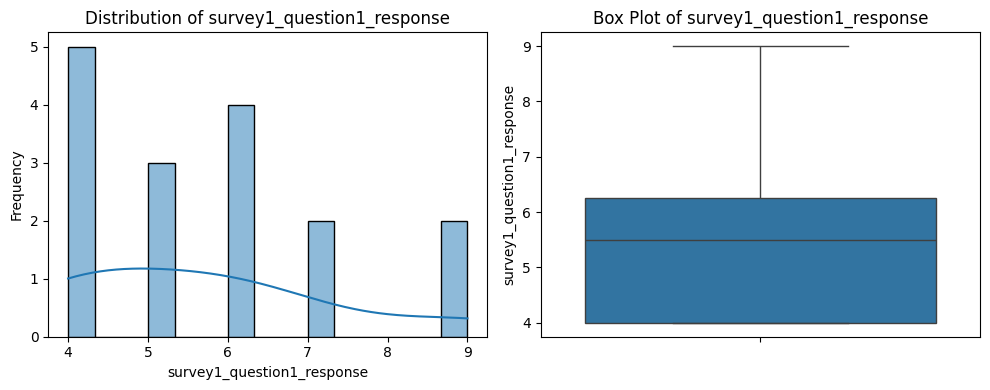

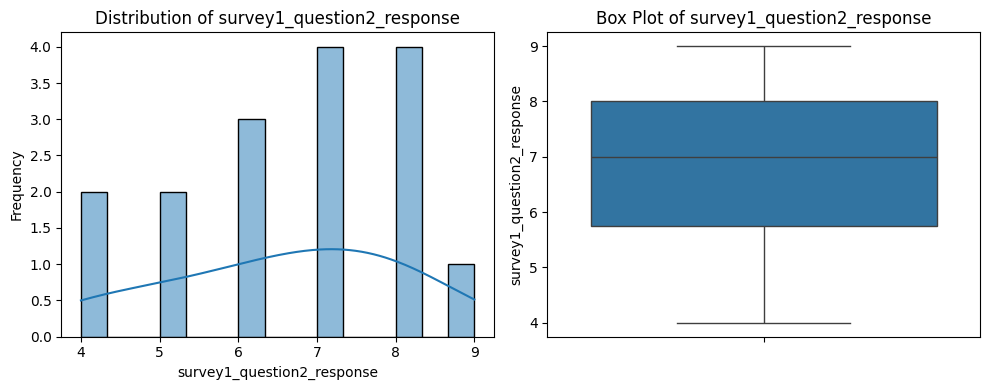

In [17]:
columns = [
    'survey1_question1_response',
    'survey1_question2_response']

for column in columns:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df_mea_o[column].dropna(), bins=15, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_mea_o[column].dropna())
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#### Line Plot

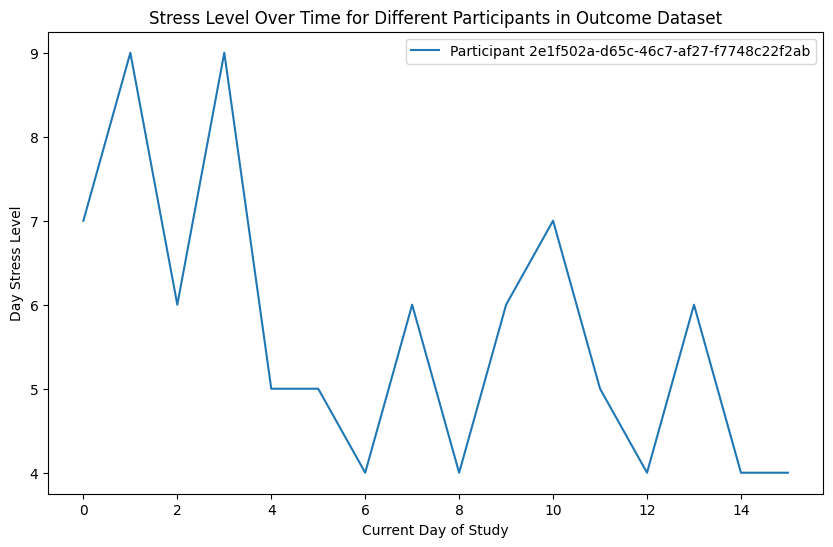

In [18]:
grouped_data = df_mea_o.groupby("participant_id")

plt.figure(figsize=(10, 6)) 

for participant_id, group in grouped_data:
    plt.plot(group['current_day_of_study'], group['survey1_question1_response'], label=f'Participant {participant_id}')

plt.xlabel('Current Day of Study')
plt.ylabel('Day Stress Level')
plt.title('Stress Level Over Time for Different Participants in Outcome Dataset')

plt.legend()
plt.show()

#### Scatterplot

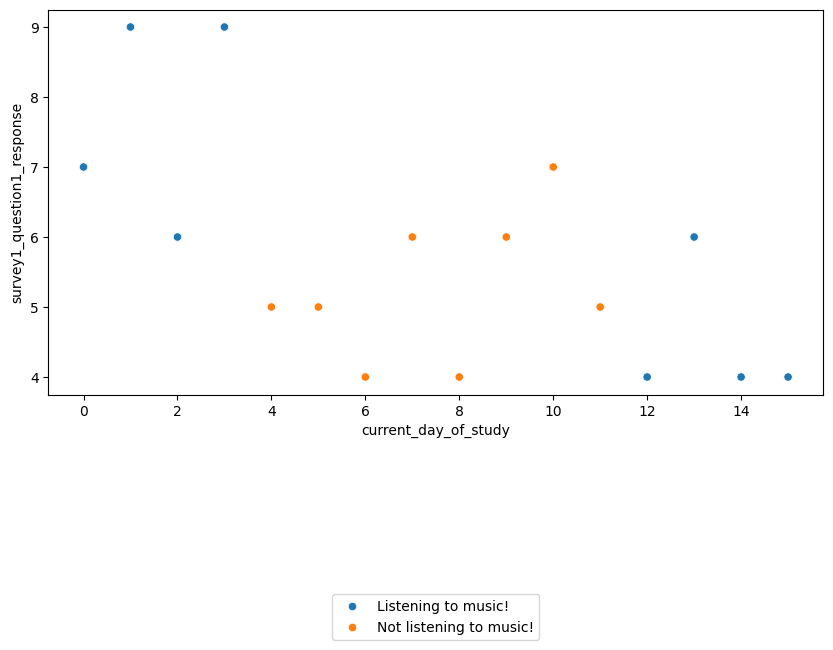

In [19]:
x = 'current_day_of_study'
y = 'survey1_question1_response'

participant_list= list(df_mea_o.participant_id.unique())
fig, axs = plt.subplots(len(participant_list), figsize=(10, 5 * len(participant_list)))

if len(participant_list) == 1:
    axs = [axs]

for i in range(len(participant_list)):
    legend = True if i == len(participant_list)-1 else False
    sns.scatterplot(
        data=df_mea_o[df_mea_o["participant_id"] == participant_list[i]],
        x=x, y=y, hue='current_intervention_name',
        ax=axs[i], legend=legend
    )

axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5))

#### Correlations

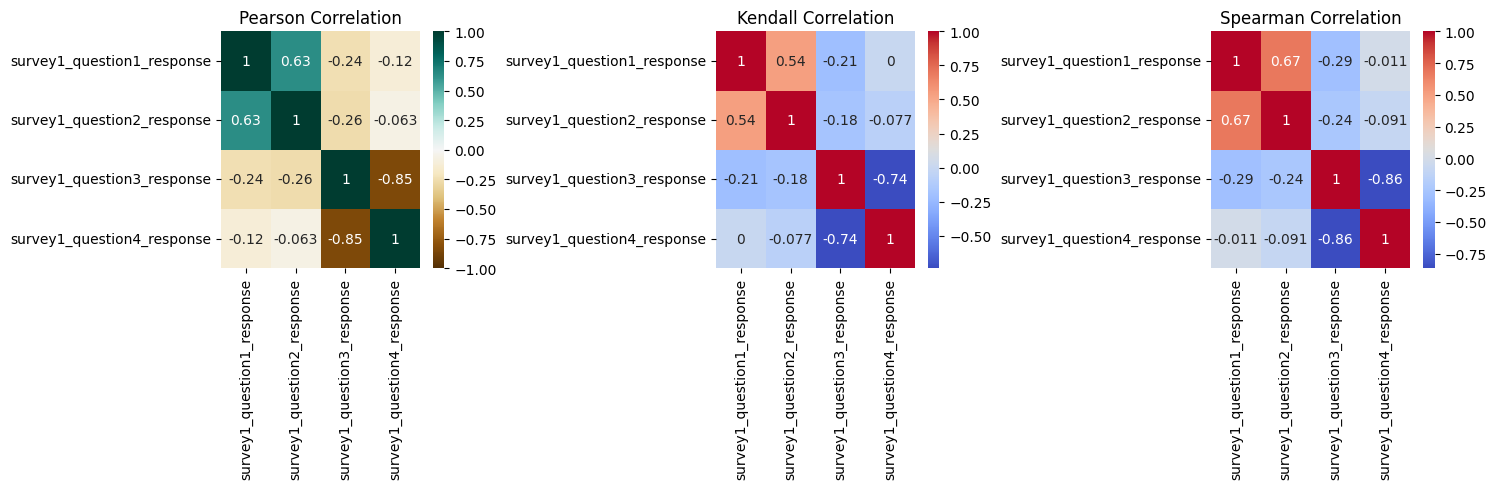

In [20]:
columns_to_include = [
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response']

correlation_pearson = df_mea_all[columns_to_include].corr(method='pearson')
correlation_kendall = df_mea_all[columns_to_include].corr(method='kendall')
correlation_spearman = df_mea_all[columns_to_include].corr(method='spearman')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(correlation_pearson, vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[0], center=0)
axes[0].set_title('Pearson Correlation')

sns.heatmap(correlation_kendall, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Kendall Correlation')

sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

## Baseline Study: Listening To Music vs Not Listening To Music

  - Baseline Studies  
    - Examination of Outcomes   
    - Linear Regression  
      - Ordinary Least Squares (OLS) Regression  
      - Linear Regression with Autoregressive Errors 
      - Bayesian linear regression models
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators
        - Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

#### Examination of Outcomes: Today Stress Level

In [21]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Listening to music!",
        "Not listening to music!"
    ])
]

listening = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Listening to music!",
    'survey1_question1_response'
]
avoid_listening = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not listening to music!",
    'survey1_question1_response'
]

n_listening        = listening.count()
n_avoid_listening  = avoid_listening.count()
std_listening      = listening.std(ddof=1)
std_avoid_listening = avoid_listening.std(ddof=1)

print(f"Listening to music:       n = {n_listening}, std = {std_listening:.2f}, mean = {listening.mean():.2f}")
print(f"Avoid listening to music: n = {n_avoid_listening}, std = {std_avoid_listening:.2f}, mean = {avoid_listening.mean():.2f}\n")

Listening to music:       n = 8, std = 2.10, mean = 6.12
Avoid listening to music: n = 8, std = 1.04, mean = 5.25



#### Examination of Outcomes: Prediction of Tomorrow Stress

In [22]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question2_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Listening to music!",
        "Not listening to music!"
    ])
]

listening = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Listening to music!",
    'survey1_question2_response'
]
avoid_listening = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not listening to music!",
    'survey1_question2_response'
]

n_listening        = listening.count()
n_avoid_listening  = avoid_listening.count()
std_listening      = listening.std(ddof=1)
std_avoid_listening = avoid_listening.std(ddof=1)

print(f"Listening to music:       n = {n_listening}, std = {std_listening:.2f}, mean = {listening.mean():.2f}")
print(f"Avoid listening to music: n = {n_avoid_listening}, std = {std_avoid_listening:.2f}, mean = {avoid_listening.mean():.2f}\n")

Listening to music:       n = 8, std = 1.85, mean = 6.50
Avoid listening to music: n = 8, std = 1.19, mean = 6.62



#### Mean Stress-Relief Score for Listening to Music (Q3)
The average score for Question 3 (survey1_question3_response), which assesses how much listening to music alleviated participants’ stress on days they performed.

In [23]:
df_mea.survey1_question3_text[0]

'How much did this method (listening to music) help you today? <b>(1 = Not helpful at all to 10 = Very helpful) <i>(Answer ONLY if you have listened to music!)</i></b>'

In [24]:
# 'How much did this method (listening to music) help you today? (1 = Not helpful at all to 10 = Very helpful) (Answer ONLY if you have listened to music!)
mean_q3_listening = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Listening to music!",
    'survey1_question3_response'
].mean()
mean_q3_listening.item()

5.75

**Mean Stress-Relief Score for Listening to Music (Q3): 5.75:**
On days when the participant listened to music, she rated Question 3—“How much did this method help you today?”—an average of 5.75 out of 10, indicating that listening to music provided a moderate benefit.

#### Mean Stress-Management Difficulty Listening to Music (Q4)
The average score for Question 4 (survey1_question4_response), which measures participants’ difficulty in managing stress on days they did not listen to music.

In [25]:
df_mea.survey1_question4_text[0]

'Did you have difficulty without the method? <b>(1 = No difficulty to 5 = Significant difficulty) <i>(Answer ONLY if you have NOT listened to music!)</i></b>'

In [26]:
# 'Did you have difficulty without the method?(1 = No difficulty to 5 = Significant difficulty)(Answer ONLY if you have NOT listened to music!)
mean_q4_no_listening = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not listening to music!",
    'survey1_question4_response'
].mean()
mean_q4_no_listening.item()

5.125

**Mean Stress-Management Difficulty Score Without Listening to Music (Q4): 8.625:**
On days when the participant did not listen to music, she rated Question 4—“Did you have difficulty without the method?”—an average of 5.12 out of 10, indicating a moderate level of difficulty in managing stress.

### Estimating treatment effect using Linear Regression with Autoregressive errors

In [27]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin(["Listening to music!", "Not listening to music!"])
]

df_mea_o = df_mea_o.sort_values('measurement_time')

y = df_mea_o['survey1_question1_response']
df_mea_o['D'] = (df_mea_o['current_intervention_name'] == "Listening to music!").astype(int)
X = sm.add_constant(df_mea_o['D'])

ols_res = sm.OLS(y, X).fit()
dw_ols = durbin_watson(ols_res.resid)

print("OLS Regression Results:")
print(ols_res.summary())
print(f"Durbin–Watson statistic (OLS residuals): {dw_ols:.3f}\n")

OLS Regression Results:
                                OLS Regression Results                                
Dep. Variable:     survey1_question1_response   R-squared:                       0.074
Model:                                    OLS   Adj. R-squared:                  0.008
Method:                         Least Squares   F-statistic:                     1.117
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.308
Time:                                14:27:20   Log-Likelihood:                -29.702
No. Observations:                          16   AIC:                             63.40
Df Residuals:                              14   BIC:                             64.95
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [28]:
glsar = sm.GLSAR(y, X, rho=1)
glsar_res = glsar.iterative_fit(maxiter=10)
dw_glsar = durbin_watson(glsar_res.resid)

print("GLSAR Regression Results (AR(1) error structure):")
print(glsar_res.summary())
print(f"Estimated AR(1) coefficient (rho): {glsar.rho[0]:.3f}")
print(f"Durbin–Watson statistic (GLSAR residuals): {dw_glsar:.3f}")

GLSAR Regression Results (AR(1) error structure):
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.045
Model:                                  GLSAR   Adj. R-squared:                 -0.028
Method:                         Least Squares   F-statistic:                    0.6147
Date:                        Wed, 13 Aug 2025   Prob (F-statistic):              0.447
Time:                                14:27:20   Log-Likelihood:                -27.997
No. Observations:                          15   AIC:                             59.99
Df Residuals:                              13   BIC:                             61.41
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


#### Bayesian AR(1) Model of Daily Stress Response to Listening to Music and Mediators

In [29]:
def run_model(fac_cols, beta_names):
    out = df_mea[df_mea['measurement_name'] == 'Outcome']
    med = df_mea[df_mea['measurement_name'] == 'Mediators']
    data = (
        pd.merge(
            out[['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']],
            med[['current_day_of_study'] + fac_cols] if fac_cols else out[['current_day_of_study']],
            on='current_day_of_study',
            how='inner'
        ).dropna().sort_values('current_day_of_study').reset_index(drop=True)
    )
    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Listening to music!").astype(int).values
    n = len(data)
    fac_arrays = [data[col].values for col in fac_cols] if fac_cols else []

    with pm.Model() as model:
        beta0 = pm.Normal('beta0', mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        betas = [pm.Normal(beta_name, mu=0, sigma=1) for beta_name in beta_names]
        rho = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)
        mu = beta0 + beta_int * interv
        for beta, fac in zip(betas, fac_arrays):
            mu += beta * fac
        pm.Normal('y_0', mu=mu[0], sigma=sigma, observed=y[0])
        for t in range(1, n):
            adjustment = rho * (y[t-1] - mu[t-1])
            pm.Normal(f'y_{t}', mu=mu[t] + adjustment, sigma=sigma, observed=y[t])
        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9, return_inferencedata=True)
    summary = az.summary(trace, var_names=['beta_int'] + beta_names + ['rho', 'sigma'], hdi_prob=0.95)
    print(summary)
    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()
    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")
    prob = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(Stress reduction of listening to music ≥ 0.5) = {prob:.2%}\n")

print("Model result with neither fac1 nor fac2 (intervention only):")
run_model([], [])

print("Model result with only fac1:")
run_model(['survey2_question1_response'], ['beta_f1'])

print("Model result with only fac2:")
run_model(['survey2_question2_response'], ['beta_f2'])

print("Model result with both fac1 and fac2:")
run_model(['survey2_question1_response', 'survey2_question2_response'], ['beta_f1', 'beta_f2'])

Model result with neither fac1 nor fac2 (intervention only):


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 178 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.535  0.703    -0.762      1.947      0.029    0.026     590.0   
rho       0.268  0.292    -0.282      0.837      0.015    0.010     390.0   
sigma     1.656  0.290     1.113      2.256      0.013    0.012     537.0   

          ess_tail  r_hat  
beta_int     685.0    1.0  
rho          353.0    1.0  
sigma        486.0    1.0  
P(beta_int ≤ –0.5) = 6.30%
P(–0.5 < beta_int < 0) = 15.40%
P(beta_int ≥ 0) = 78.30%
P(Stress reduction of listening to music ≥ 0.5) = 6.30%

Model result with only fac1:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 326 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.175  0.578    -0.945      1.325      0.025    0.026     535.0   
beta_f1   0.955  0.240     0.523      1.477      0.014    0.009     283.0   
rho       0.036  0.353    -0.700      0.695      0.018    0.011     389.0   
sigma     1.142  0.225     0.744      1.548      0.010    0.008     450.0   

          ess_tail  r_hat  
beta_int     430.0    1.0  
beta_f1      413.0    1.0  
rho          468.0    1.0  
sigma        565.0    1.0  
P(beta_int ≤ –0.5) = 12.20%
P(–0.5 < beta_int < 0) = 24.40%
P(beta_int ≥ 0) = 63.40%
P(Stress reduction of listening to music ≥ 0.5) = 12.20%

Model result with only fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 218 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.557  0.699    -0.954      1.842      0.029    0.024     575.0   
beta_f2  -0.027  0.269    -0.522      0.506      0.014    0.011     371.0   
rho       0.304  0.297    -0.241      0.900      0.014    0.016     452.0   
sigma     1.703  0.305     1.159      2.276      0.014    0.013     492.0   

          ess_tail  r_hat  
beta_int     591.0   1.00  
beta_f2      404.0   1.00  
rho          307.0   1.01  
sigma        627.0   1.00  
P(beta_int ≤ –0.5) = 6.70%
P(–0.5 < beta_int < 0) = 13.60%
P(beta_int ≥ 0) = 79.70%
P(Stress reduction of listening to music ≥ 0.5) = 6.70%

Model result with both fac1 and fac2:


Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 385 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  0.203  0.540    -0.712      1.290      0.021    0.019     663.0   
beta_f1   0.968  0.243     0.516      1.448      0.011    0.008     503.0   
beta_f2  -0.104  0.191    -0.482      0.251      0.008    0.007     659.0   
rho       0.084  0.339    -0.515      0.796      0.019    0.019     351.0   
sigma     1.158  0.218     0.785      1.558      0.008    0.007     809.0   

          ess_tail  r_hat  
beta_int     751.0   1.00  
beta_f1      536.0   1.01  
beta_f2      504.0   1.00  
rho          181.0   1.00  
sigma        599.0   1.00  
P(beta_int ≤ –0.5) = 8.90%
P(–0.5 < beta_int < 0) = 28.90%
P(beta_int ≥ 0) = 62.20%
P(Stress reduction of listening to music ≥ 0.5) = 8.90%



#### Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

Initializing NUTS using jitter+adapt_diag...
c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 127 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int  1.069  1.017    -0.755      3.262      0.044    0.034     544.0   
rho       0.326  0.320    -0.269      0.923      0.015    0.009     451.0   
sigma     1.807  0.359     1.174      2.557      0.016    0.014     469.0   

          ess_tail  r_hat  
beta_int     577.0   1.00  
rho          463.0   1.01  
sigma        587.0   1.00  
P(beta_int ≤ –0.5) = 5.40%
P(–0.5 < beta_int < 0) = 7.60%
P(beta_int ≥ 0) = 87.00%


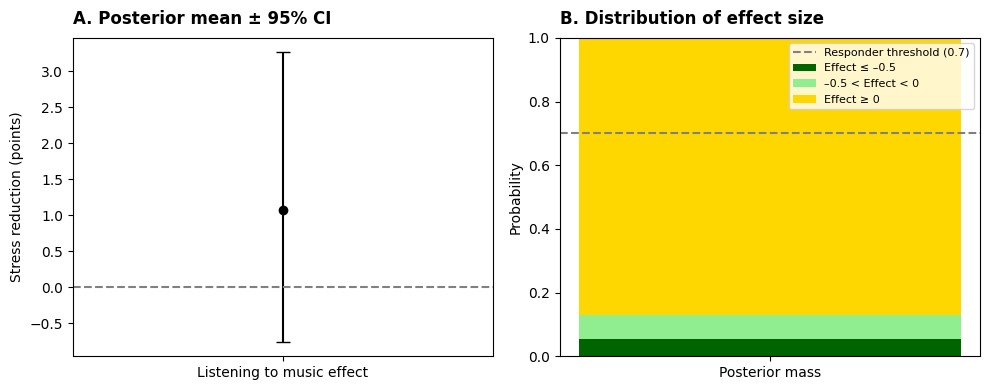

In [30]:
outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
data = (
    outcome_data[['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']]
    .dropna()
    .sort_values('current_day_of_study')
    .reset_index(drop=True)
)

y      = data['survey1_question1_response'].values
interv = (data['current_intervention_name'] == "Listening to music!").astype(int).values
n      = len(data)

mad = np.median(np.abs(y - np.median(y)))
scale = max(mad, 2.0)

with pm.Model() as model:
    beta0    = pm.StudentT('beta0',    nu=3, mu=0, sigma=scale)   
    beta_int = pm.StudentT('beta_int', nu=3, mu=0, sigma=scale)   
    rho      = pm.Uniform('rho',       lower=-1, upper=1)         
    sigma    = pm.HalfStudentT('sigma', nu=3, sigma=scale)        

    mu = beta0 + beta_int * interv

    pm.Normal('y_0', mu=mu[0], sigma=sigma, observed=y[0])

    for t in range(1, n):
        adjustment = rho * (y[t-1] - mu[t-1])
        pm.Normal(f'y_{t}', mu=mu[t] + adjustment, sigma=sigma, observed=y[t])

    trace = pm.sample(
        draws=500,
        tune=500,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True
    )

summary = az.summary(trace, var_names=['beta_int', 'rho', 'sigma'], hdi_prob=0.95)
print(summary)

beta_samples = trace.posterior['beta_int'].values.flatten()

p_le_neg05 = (beta_samples <= -0.5).mean()
p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
p_ge0      = (beta_samples >= 0).mean()

print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

mean_beta = summary.loc['beta_int', 'mean']
hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

ax = axes[0]
ax.errorbar(0, mean_beta,
            yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
            fmt='o', capsize=5, color='black')
ax.axhline(0, color='gray', linestyle='--')
ax.set_xticks([0])
ax.set_xticklabels(['Listening to music effect'])
ax.set_ylabel('Stress reduction (points)')
ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

ax = axes[1]
ax.bar(0, p_le_neg05, width=0.6, color='darkgreen',  label='Effect ≤ –0.5')
ax.bar(0, p_between,  width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < Effect < 0')
ax.bar(0, p_ge0,      width=0.6, bottom=p_le_neg05+p_between, color='gold', label='Effect ≥ 0')
ax.axhline(0.7, color='gray', linestyle='--', label='Responder threshold (0.7)')
ax.set_xticks([0])
ax.set_xticklabels(['Posterior mass'])
ax.set_ylim(0, 1)
ax.set_ylabel('Probability')
ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()